<a href="https://colab.research.google.com/github/yucellgereklioglu/datasciencework/blob/main/Colab'e_ho%C5%9F_geldiniz_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Kendi verilerinizi Google Drive hesabınızdan &#40;e-tablolar dahil&#41;, GitHub'dan ve diğer pek çok kaynaktan Colab not defterlerine aktarabilirsiniz. Veri içe aktarma ve Colab'in veri bilimi için nasıl kullanılabileceği hakkında daha fazla bilgi edinmek için <a href="#working-with-data">Verilerle Çalışma</a> bölümünün altındaki bağlantılara bakabilirsiniz.

In [1]:
from sklearn.linear_model import LinearRegression, Ridge
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import RandomizedSearchCV, train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [3]:
df=pd.read_csv('/content/company_esg_financial_dataset.csv')
le=LabelEncoder()
df['CompanyName']=le.fit_transform(df['CompanyName'])
df['Region']=le.fit_transform(df['Region'])
df['Industry']=le.fit_transform(df['Industry'])

In [5]:
df.fillna(df.mean(),inplace=True)

In [6]:
y=df['MarketCap']
x=df.drop(['MarketCap'],axis=1)

In [7]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,shuffle=True,random_state=42)

In [14]:
param_dist = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 1.0],
}
xgb=XGBRegressor()
random_search_xgb = RandomizedSearchCV(estimator=xgb, param_distributions=param_dist, n_iter=10, cv=5, n_jobs=-1)
random_search_xgb.fit(x_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          feature_weights=None, gamma=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraint...
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=None,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None, ...),
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [3, 4, 5],
                                        'n_estimators': [50, 100, 150],
                                        'subsample': [0.7, 0.8, 1.0]})

In [15]:
param_dt = {
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}
dt=DecisionTreeRegressor()
random_search_dt = RandomizedSearchCV(estimator=dt, param_distributions=param_dt, n_iter=10, cv=5, n_jobs=-1)
random_search_dt.fit(x_train, y_train)

RandomizedSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_jobs=-1,
                   param_distributions={'max_depth': [3, 4, 5],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10]})

In [44]:
bestxgb=random_search_xgb.best_estimator_
bestdt=random_search_dt.best_estimator_
bestxgb.fit(x_train,y_train)
bestdt.fit(x_train,y_train)

DecisionTreeRegressor(max_depth=5, min_samples_leaf=4, min_samples_split=5)

In [17]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold

In [45]:
metamodel=Ridge(alpha=1.0)
basemodel=[bestxgb,bestdt]
y_pred_meta=[]
kf=KFold(n_splits=5,shuffle=True,random_state=42)
for train_index,test_index in kf.split(x_train):
  x_train_fold,x_test_fold=x_train.iloc[train_index],x_train.iloc[test_index]


In [47]:
from sklearn.ensemble import StackingRegressor
stackingregressor=StackingRegressor(estimators=[('xgb', bestxgb), ('dt', bestdt)],final_estimator=metamodel)
stackingregressor.fit(x,y)

StackingRegressor(estimators=[('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            feature_weights=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constra...
                                            learning_rate=0.05, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=4,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=150, n_jobs=None,
                                            num_parallel_tree=None, ...)),
                              ('dt',
                               DecisionTreeRegressor(max_depth=5,
                                                     min_samples_leaf=4,
                                                     min_samples_split=5))],
                  final_estimator=Ridge())

In [57]:
from sklearn.metrics import mean_squared_error, r2_score
y_pred_meta=stackingregressor.predict(x_test)
mse=mean_squared_error(y_test,y_pred_meta)
r2=r2_score(y_test,y_pred_meta)
rmse=np.sqrt(mse)
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared: {r2}")

Mean Squared Error: 56719664.28398122
Root Mean Squared Error: 7531.245865325419
R-squared: 0.9739531033658563


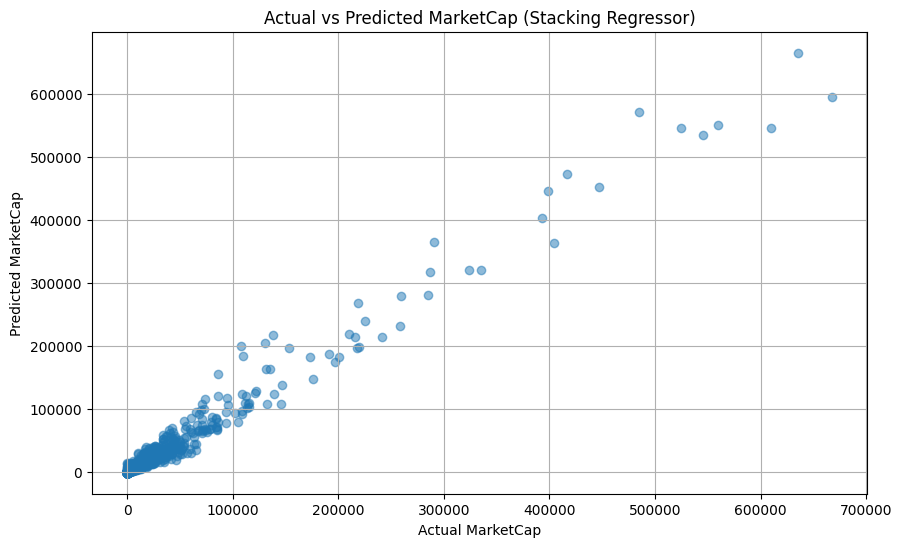

In [59]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_meta, alpha=0.5)
plt.xlabel("Actual MarketCap")
plt.ylabel("Predicted MarketCap")
plt.title("Actual vs Predicted MarketCap (Stacking Regressor)")
plt.grid(True)
plt.show()

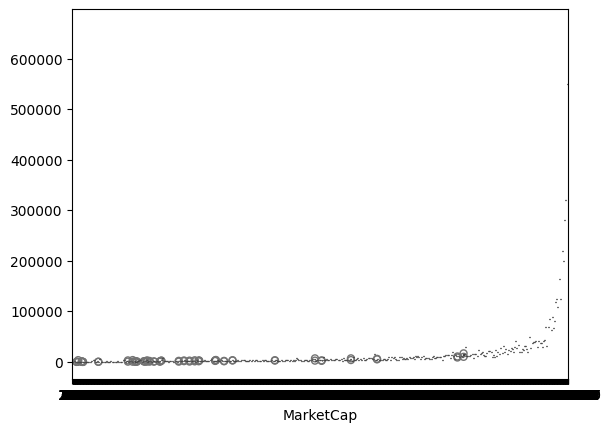

In [60]:
sns.boxenplot(x=y_test,y=y_pred_meta)
plt.show()